In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
import os
from google.colab import drive
import os
from getpass import getpass
import urllib

ModuleNotFoundError: No module named 'google'

# Get Data from GitHub

## Clone repo

Run this:

Wait one or two minutes before moving on, because the repository is being cloned. If you got an error saying that get_data does not exist, wait for 30 seconds and try again.
This will clone the repository to your local environement.  

In [ ]:
! git clone https://github.com/charlesmilk/covid19.git

In [ ]:
! python covid19/get_data.py

# Load Data

In [2]:
confirmed = pd.read_csv('data/time_series_19-covid-Confirmed.csv')
deaths = pd.read_csv('data/time_series_19-covid-Deaths.csv')
recover = pd.read_csv('data/time_series_19-covid-Recovered.csv')

Data problem in the 3/11/20 - I will remove that day

In [3]:
confirmed = confirmed[confirmed.columns[confirmed.columns != '3/11/20']]

In [4]:
day = datetime.today() - timedelta(days=2)

In [5]:
datastr = day.strftime('%m/%d')[1:] + '/20'

# Data transformation

In [6]:
confirmed_by_country = confirmed[['Country/Region', datastr]].groupby('Country/Region').sum().rename(columns={datastr: 'n_confirmed'})

In [7]:
deaths_by_country = deaths[['Country/Region', datastr]].groupby('Country/Region').sum().rename(columns={datastr: 'n_deaths'})

In [8]:
recover_by_country = recover[['Country/Region', datastr]].groupby('Country/Region').sum().rename(columns={datastr: 'n_recover'})

In [9]:
global_df = confirmed_by_country.merge(deaths_by_country, how='left', left_index=True, right_index=True).\
merge(recover_by_country, how='left', left_index=True, right_index=True)

In [10]:
confirmed_country_day = confirmed.drop(['Province/State', 'Lat', 'Long'], axis=1).groupby('Country/Region').sum()

In [11]:
recover_country_day = recover.drop(['Province/State', 'Lat', 'Long'], axis=1).groupby('Country/Region').sum()

In [12]:
deaths_country_day = deaths.drop(['Province/State', 'Lat', 'Long'], axis=1).groupby('Country/Region').sum()

In [13]:
ndays_since_first_confirmed = confirmed_country_day.apply(lambda x: (x > 0).sum(), axis=1)

In [14]:
ndays_since_first10_confirmed = confirmed_country_day.apply(lambda x: (x >= 10).sum(), axis=1)

In [15]:
ndays_since_first_death = deaths_country_day.apply(lambda x: (x > 0).sum(), axis=1)

In [16]:
ndays_since_first_recovery = recover_country_day.apply(lambda x: (x > 0).sum(), axis=1)

In [17]:
global_df = global_df.merge(ndays_since_first_confirmed.rename('days'), right_index=True, left_index=True)

In [18]:
global_df = global_df.merge(ndays_since_first_death.rename('ndays_since_first_death'), right_index=True, left_index=True)

In [19]:
global_df = global_df.merge(ndays_since_first_recovery.rename('ndays_since_first_recover'), right_index=True, left_index=True)

In [20]:
global_df = global_df.merge(ndays_since_first10_confirmed.rename('ndays_since_first10_confirmed'), right_index=True, left_index=True)

In [21]:
global_df['unk_state'] = global_df.n_confirmed-global_df.n_deaths-global_df.n_recover

# Analysis

In [22]:
print(f"{global_df.shape[0]} coutries with confirmed cases so far, {global_df.n_confirmed.sum()} confirmed cases, \
{global_df.n_deaths.sum()} deaths and {global_df.n_recover.sum()} recovers.")

143 coutries with confirmed cases so far, 145193 confirmed cases, 5404 deaths and 70251 recovers.


In [23]:
global_df.loc[['Italy', 'China', 'Spain', 'France', 'Netherlands', 'Portugal', 'Germany', 'United Kingdom'], 
              ['n_confirmed', 'days', 'ndays_since_first10_confirmed']]

,n_confirmed,days,ndays_since_first10_confirmed
Country/Region,,,
Italy,17660,43,22
China,80945,52,52
Spain,5232,42,17
France,3667,50,35
Netherlands,804,16,13
Portugal,112,12,8
Germany,3675,47,41
United Kingdom,801,43,19


In [24]:
today = (timedelta(days=-1)+datetime.today()).strftime('%d-%m-%Y')

In [25]:
#minimize the required number of different colors within the color palette
countries = ['China', 'Spain', 'Italy', 'France', 'Netherlands', 'Germany', 'Portugal', 'United Kingdom', 'US'
            , 'Korea, South', 'Iran']

colors = sns.color_palette('tab20', n_colors=len(countries))  # a list of RGB tuples

color_map = dict(zip(countries, colors))

In [26]:
country_data = confirmed_country_day.loc['Portugal']
country_data = country_data[country_data>=10]

pt_days = len(country_data)

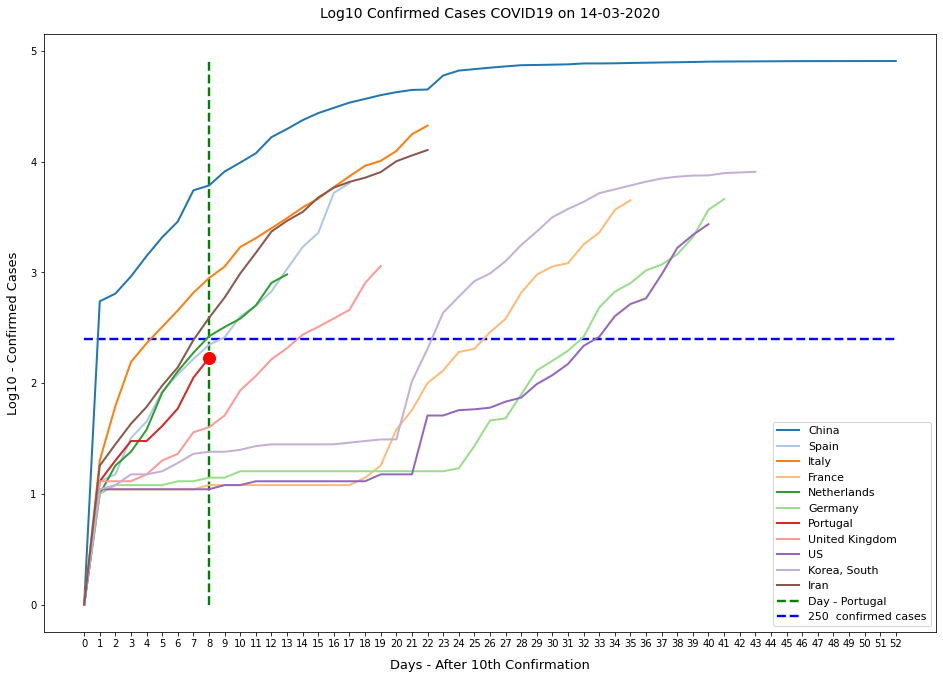

In [27]:

max_total = 0
max_days = 0
plt.figure(figsize=(16,11))


for i, country in enumerate(countries):
    country_data = confirmed_country_day.loc[country]
    country_data = country_data[country_data>=10]
    
    if len(country_data.values) > max_days:
        max_days = len(country_data)
    
    vals = np.log10(country_data.values)
    maxval = vals.max()
    if maxval > max_total:
        max_total = maxval
    
    plt.plot(list(range(len(country_data)+1)), np.concatenate((np.array([0]),vals)), 
             label=country, color=color_map[country], linewidth=2)
    
_ = plt.xticks(ticks=list(range(0,max_days+1)))
_ = plt.vlines(x=pt_days, ymin=0, ymax=max_total, linestyles='dashed', colors='g', label='Day - Portugal',
              linewidth=2.4)   

_ = plt.hlines(y=np.log10(250), xmin=0, xmax=max_days, linestyles='dashed', colors='b', label='250  confirmed cases',
              linewidth=2.4)  

_ = plt.legend(loc='lower right', fontsize=11)
_ = plt.title(f'Log10 Confirmed Cases COVID19 on {today}', fontdict={'fontsize':14}, pad=16.0)
_ = plt.xlabel('Days - After 10th Confirmation', fontdict={'fontsize':13}, labelpad=10.0)
_ = plt.ylabel('Log10 - Confirmed Cases', fontdict={'fontsize':13}, labelpad=10.0)

country_data = confirmed_country_day.loc['Portugal']
country_data = country_data[country_data>=10]
_ = plt.plot(len(country_data), np.log10(country_data[-1]), 'ro', markersize=12)
plt.savefig('data/nconfirmed_log.png')

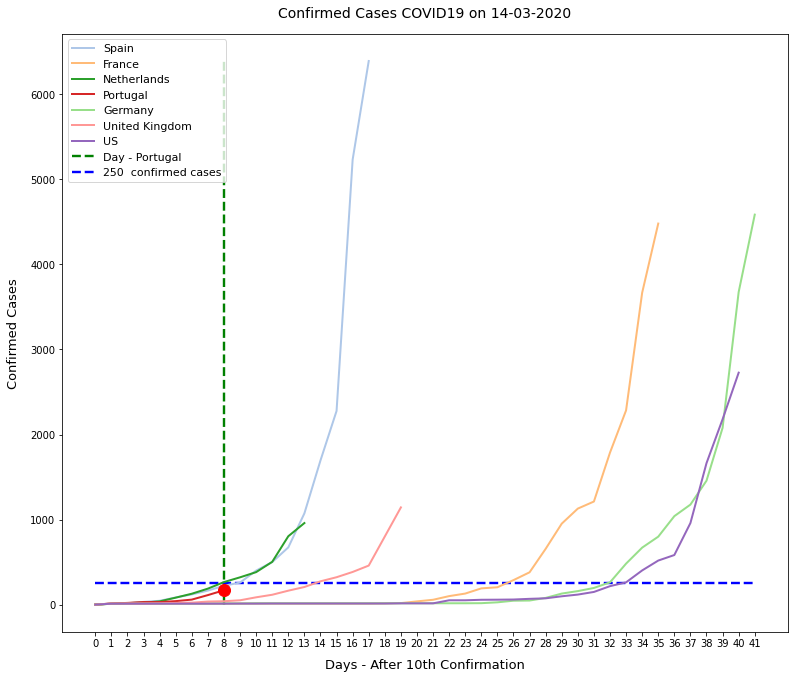

In [28]:
countries = ['Spain', 'France', 'Netherlands', 'Portugal', 'Germany', 'United Kingdom', 'US']
max_total = 0
max_days = 0

plt.figure(figsize=(13,11))

for i, country in enumerate(countries):
    country_data = confirmed_country_day.loc[country]
    country_data = country_data[country_data>=10]
    
    if len(country_data.values) > max_days:
        max_days = len(country_data)
    
    vals = country_data.values
    maxval = vals.max()
    if maxval > max_total:
        max_total = maxval
    
    plt.plot(list(range(len(country_data)+1)), np.concatenate((np.array([0]),vals)), 
             label=country, color=color_map[country], linewidth=2)

_ = plt.xticks(ticks=list(range(0,max_days+1)))
_ = plt.vlines(x=pt_days, ymin=0, ymax=max_total, linestyles='dashed', colors='g', label='Day - Portugal',
              linewidth=2.4) 
_ = plt.hlines(y=250, xmin=0, xmax=max_days, linestyles='dashed', colors='b', label='250  confirmed cases',
              linewidth=2.4)  
_ = plt.legend(loc='upper left', fontsize=11)
_ = plt.title(f'Confirmed Cases COVID19 on {today}', fontdict={'fontsize':14}, pad=16.0)
_ = plt.xlabel('Days - After 10th Confirmation', fontdict={'fontsize':13}, labelpad=10.0)
_ = plt.ylabel('Confirmed Cases', fontdict={'fontsize':13}, labelpad=10.0)

country_data = confirmed_country_day.loc['Portugal']
country_data = country_data[country_data>=10]
_ = plt.plot(len(country_data), country_data[-1], 'ro', markersize=12)
plt.savefig('data/nconfirmed_normal.png')

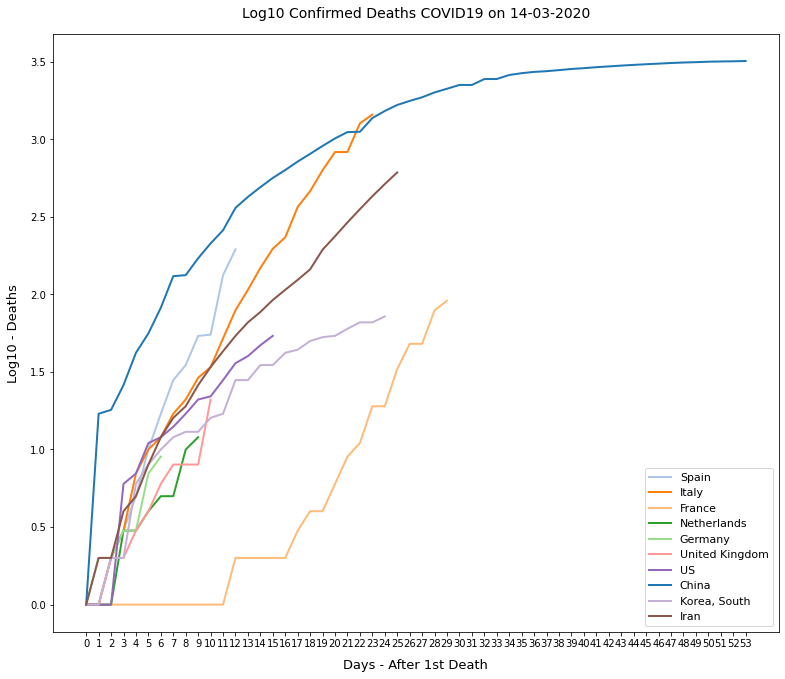

In [29]:
countries = ['Spain', 'Italy', 'France', 'Netherlands', 'Germany', 'United Kingdom', 'US', 'China', 
             'Korea, South', 'Iran']
max_total = 0
max_days = 0

plt.figure(figsize=(13,11))

for i, country in enumerate(countries):
    country_data = deaths_country_day.loc[country]
    country_data = country_data[country_data>=1]
    
    if len(country_data.values) > max_days:
        max_days = len(country_data)
    
    vals = np.log10(country_data.values)
    maxval = vals.max()
    if maxval > max_total:
        max_total = maxval
    
    plt.plot(list(range(len(country_data)+1)), np.concatenate((np.array([0]),vals)), 
             label=country, color=color_map[country], linewidth=2)

_ = plt.xticks(ticks=list(range(0,max_days+1)))
_ = plt.legend(loc='lower right', fontsize=11)
_ = plt.title(f'Log10 Confirmed Deaths COVID19 on {today}', fontdict={'fontsize':14}, pad=16.0)
_ = plt.xlabel('Days - After 1st Death', fontdict={'fontsize':13}, labelpad=10.0)
_ = plt.ylabel('Log10 - Deaths', fontdict={'fontsize':13}, labelpad=10.0)
plt.savefig('data/deathslog.png')

In [30]:
global_df.loc[['China', 'Italy'], 'n_deaths'] / global_df.loc[['China', 'Italy'], 'n_confirmed']

Country/Region
China    0.039286
Italy    0.071687
dtype: float64

# Models

In [31]:
def logistic(x, a, k):
    return 1 / (1 + np.exp(-k * (x - a)))

In [32]:
def exponential_portugal(x,z,k,c):
    return z*np.exp(x*k)+c

In [33]:
def exponential(x,z,k):
    return z**(x*k)

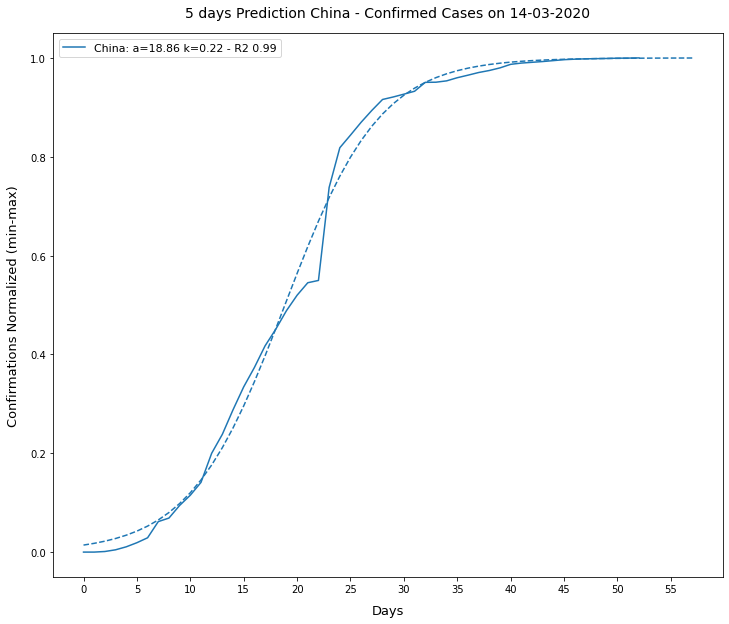

In [34]:
selected_country = 'China'

ndays_prev = 5
plt.figure(figsize=(12,10))

country_y = confirmed_country_day.loc[selected_country]
country_y = (country_y - country_y.min()) / (country_y.max() - country_y.min())

country_y = np.concatenate((np.array([0]),country_y))
xdata_real = list(range(len(country_y)))

popt, pcov = curve_fit(logistic, xdata_real, country_y)
xdata_all = xdata_real + [i for i in range(xdata_real[-1], xdata_real[-1]+ndays_prev+1)]

prevs_to_plot = logistic(np.array(xdata_all), *popt)
predicted_func = logistic(np.array(xdata_real), *popt)
coefficient_of_dermination = r2_score(country_y,  predicted_func)


plt.plot(xdata_all, prevs_to_plot, linestyle='dashed', color=color_map[selected_country])
plt.plot(xdata_real, country_y, color=color_map[selected_country], \
         label=f"China: a={round(popt[0], 2)} k={round(popt[1], 2)} - R2 {round(coefficient_of_dermination,2)}")

_ = plt.xticks(ticks=[x for x in xdata_all if x%5 == 0])
plt.legend(loc='upper left', fontsize=11)
_ = plt.title(f'5 days Prediction China - Confirmed Cases on {today}', fontdict={'fontsize':14}, pad=16.0)
_ = plt.xlabel('Days', fontdict={'fontsize':13}, labelpad=10.0)
_ = plt.ylabel('Confirmations Normalized (min-max)', fontdict={'fontsize':13}, labelpad=10.0)
plt.savefig('data/modelchina.png')

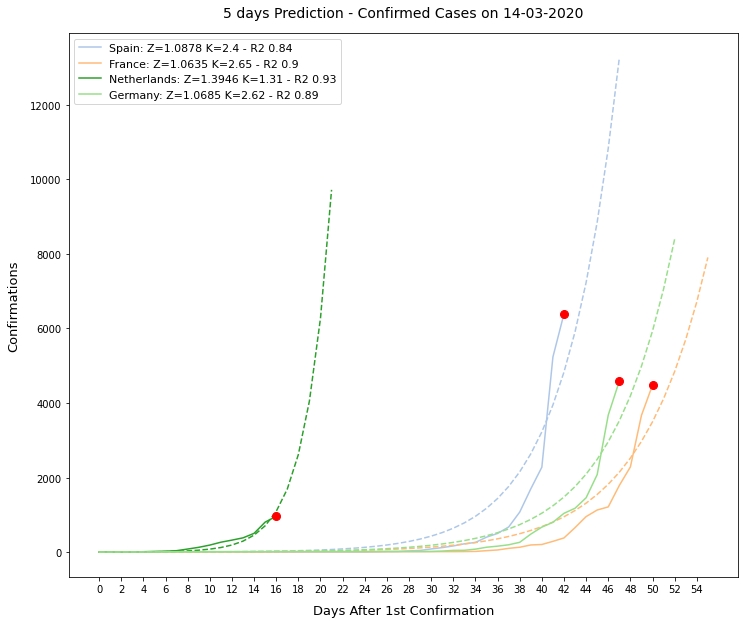

In [35]:
ndays_prev = 5
plt.figure(figsize=(12,10))
countries = ['Spain', 'France', 'Netherlands', 'Germany']
maximum = 0

for i, country_name in enumerate(countries):
    country_y = confirmed_country_day.loc[country_name]
    country_y = country_y[country_y>=1]
    
    country_y = np.concatenate((np.array([0]),country_y))
    xdata_real = list(range(len(country_y)))
    
    popt, pcov = curve_fit(exponential, xdata_real, country_y)
    xdata_all = xdata_real + [i for i in range(xdata_real[-1]+1, xdata_real[-1]+ndays_prev+1)]
    
    if xdata_all[-1] > maximum:
        maximum = xdata_all[-1]
    
    prevs_to_plot = exponential(np.array(xdata_all), *popt)
    predicted_func = exponential(np.array(xdata_real), *popt)
    coefficient_of_dermination = r2_score(country_y,  predicted_func)

    
    plt.plot(xdata_all, prevs_to_plot, linestyle='dashed', color=color_map[country_name])
    plt.plot(xdata_real, country_y, color=color_map[country_name], \
             label=f"{country_name}: Z={round(popt[0], 4)} K={round(popt[1], 2)} - R2 {round(coefficient_of_dermination,2)}")
    _ = plt.plot(len(country_y)-1, country_y[-1], 'ro', markersize=8)
        
_ = plt.xticks(ticks=[i for i in range(0, maximum+1) if i % 2 == 0])
plt.legend(loc='upper left', fontsize=11)
_ = plt.title(f'5 days Prediction - Confirmed Cases on {today}', fontdict={'fontsize':14}, pad=16.0)
_ = plt.xlabel('Days After 1st Confirmation', fontdict={'fontsize':13}, labelpad=10.0)
_ = plt.ylabel('Confirmations', fontdict={'fontsize':13}, labelpad=10.0)
plt.savefig('data/modeleurope.png')

We already have the resuls for Portugal for today:

https://covid19.min-saude.pt/ponto-de-situacao-atual-em-portugal/

In [36]:
cases_today = 248

In [37]:
today = datetime.today().strftime('%d-%m-%Y')

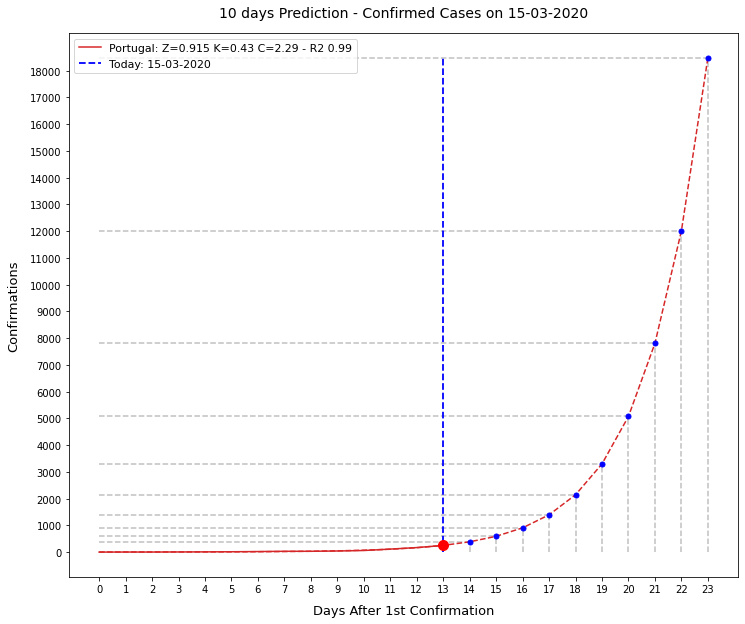

In [38]:
ndays_prev = 10
colors = cm.get_cmap('Dark2').colors
plt.figure(figsize=(12,10))
countries = ['Portugal']
maximum = 0

for i, country_name in enumerate(countries):
    country_y = confirmed_country_day.loc[country_name]
    country_y = country_y[country_y>=1]
    
    country_y = np.concatenate((np.array([0]),country_y))
    country_y = np.concatenate((country_y, np.array([cases_today])))
    xdata_real = list(range(len(country_y)))
    
    popt, pcov = curve_fit(exponential_portugal, xdata_real, country_y)
    x_data_prev = [i for i in range(xdata_real[-1]+1, xdata_real[-1]+ndays_prev+1)]
    xdata_all = xdata_real + x_data_prev
    
    if xdata_all[-1] > maximum:
        maximum = xdata_all[-1]
    
    prevs_to_plot = exponential_portugal(np.array(xdata_all), *popt)
    predicted_func = exponential_portugal(np.array(xdata_real), *popt)
    coefficient_of_dermination = r2_score(country_y,  predicted_func)

    
    plt.plot(xdata_all, prevs_to_plot, linestyle='dashed', color=color_map[country_name])
    plt.plot(xdata_real, country_y, color=color_map[country_name], \
             label=f"{country_name}: Z={round(popt[0], 3)} K={round(popt[1], 2)} C={round(popt[2], 2)} - R2 {round(coefficient_of_dermination,2)}")
    _ = plt.plot(len(country_y)-1, country_y[-1], 'ro', markersize=10)
    
    yprevs = prevs_to_plot[(xdata_real[-1]+1):].astype(int).tolist()        
        
    for yprev, xday in zip(yprevs, x_data_prev):
        _ = plt.vlines(x=xday, ymin=0,  ymax=yprev, linestyles='dashed', colors='silver')
        _ = plt.hlines(y=yprev, xmin=0, xmax=xday, linestyles='dashed', colors='silver')
        _ = plt.plot(xday, yprev, 'bo', markersize=5)
    
_ = plt.vlines(x=xdata_real[-1], ymin=0, ymax=prevs_to_plot[-1], linestyles='dashed', colors='b', label=f'Today: {today}',
              linewidth=1.8)        
_ = plt.xticks(ticks=list(range(0, maximum+1)))
_ = plt.yticks(ticks=list(range(0, prevs_to_plot[-1].astype(int), 1000)))
plt.legend(loc='upper left', fontsize=11)
_ = plt.title(f'10 days Prediction - Confirmed Cases on {today}', fontdict={'fontsize':14}, pad=16.0)
_ = plt.xlabel('Days After 1st Confirmation', fontdict={'fontsize':13}, labelpad=10.0)
_ = plt.ylabel('Confirmations', fontdict={'fontsize':13}, labelpad=10.0)
plt.savefig('data/modelportugal.png')

In [39]:
days_prev_date = [(timedelta(days=i) + datetime.now()).strftime('%d-%m-%Y') for i in range(1,11)]

In [40]:
pd.DataFrame(yprevs, index=days_prev_date, columns=['Predicted Number of Confirmations'])

,Predicted Number of Confirmations
16-03-2020,384
17-03-2020,589
18-03-2020,906
19-03-2020,1393
20-03-2020,2143
21-03-2020,3296
22-03-2020,5071
23-03-2020,7803
24-03-2020,12006
25-03-2020,18474


## Differences in population %

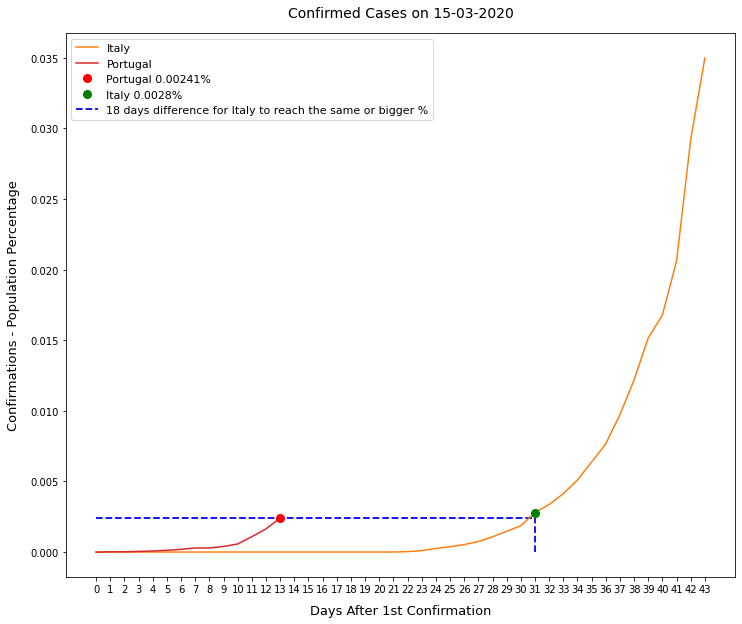

In [41]:
ndays_prev = 5

pt = confirmed_country_day.loc['Portugal']
pt = pt[pt>=1]
pt = np.concatenate((pt, np.array([cases_today])))

it = confirmed_country_day.loc['Italy']
it = it[it>=1]

pt_per_pop =  pt / 10280000
it_per_pop = it / 60480000


countries = {'Italy': it_per_pop, 'Portugal': pt_per_pop}
maximum = 0

plt.figure(figsize=(12,10))
for country_name, pop in countries.items():
    
    pop = np.concatenate((np.array([0]),pop))
    xdata_real = list(range(len(pop)))
    
    if xdata_real[-1] > maximum:
        maximum = xdata_real[-1]
    plt.plot(xdata_real, pop*100, color=color_map[country_name],label=f"{country_name}")

    
idx_it = np.where(it_per_pop >= pt_per_pop[-1])[0][0]
day_it = idx_it+1
_ = plt.plot(len(pt_per_pop), pt_per_pop[-1]*100, 'ro', markersize=8, label=f'Portugal {np.round(pt_per_pop[-1]*100,5)}%')
_ = plt.plot(day_it, it_per_pop[idx_it]*100, 'go', markersize=8, label=f'Italy {np.round(it_per_pop[idx_it]*100,5)}%')
    
_ = plt.vlines(x=day_it, ymin=0, ymax=pt_per_pop.max()*100, linestyles='dashed', colors='b', 
               label=f'{day_it-len(pt_per_pop)} days difference for Italy to reach the same or bigger %',
              linewidth=1.8)

_ = plt.hlines(y=pt_per_pop[-1]*100, xmin=0, xmax=day_it, linestyles='dashed', colors='b',
              linewidth=1.8) 

_ = plt.xticks(ticks=[i for i in range(0, maximum+1)])
plt.legend(loc='upper left', fontsize=11)
_ = plt.title(f'Confirmed Cases on {today}', fontdict={'fontsize':14}, pad=16.0)
_ = plt.xlabel('Days After 1st Confirmation', fontdict={'fontsize':13}, labelpad=10.0)
_ = plt.ylabel('Confirmations - Population Percentage', fontdict={'fontsize':13}, labelpad=10.0)
plt.savefig('data/behindit.png')